# Modelling Simple Harmonic Jitter
The goal here is to model the effect of jitter (instability in the pointing of a telescope) on the image. Here we will assume that the telescope is vibrating at high frequency back and forth in one-dimension, following a simple harmonic motion. One would expect the result of this jitter to appear like a blur with two peaks at the extremity of its excursion, as those are the positions at which the detector spends the most time during its exposure. Let us derive analytically what that function looks like.

## Deriving the analytic form of convolution kernel.

For now, let's just work in one-dimension. Eventually we are going to want to model this by creating a convolution kernel of this weird peaky function, and convolve it with our stable image. So one-dimension works for now, as we can extrapolate to two-dimensions by hitting our one-dimensional result with a rotation matrix.

The telescope pointing varies according to simple harmonic motion (SHM):

$$ x(t) = A\sin(t), $$

with inverse function (will be important later):

$$ t(x) = \arcsin(x/A). $$

We will ignore the frequency as we are assuming a single period is significantly shorter than the detector integration time. The convolution kernel will be the probability distribution function (PDF) of this SHM. This makes sense, as the PDF is proportional to how long the telescope spends in each part of the oscillation path. 

We can consider a random variable $X$, representing the position of telescope pointing, which has a PDF of $f(x)$:

$$ P(x_1 < X < x_2) = \int_{x_1}^{x_2}f(x) \, dx. $$

We want to find this function $f(x)$. Since we consider the income of photons to be approximately uniform in time, we can consider a uniform random variable $T$ representing the time sampling. Given $T$ is uniformly sampled, $T$ will have a PDF of $g(t)=1/\pi$, as $\pi$ is the range of defined outputs of $t(x)$, and thus the _domain_ of $g(t(x))$. We can write:

$$ P(t_1 < T < t_2) = \int_{t_1}^{t_2} g(t) \, dt = \frac{1}{\pi}\int_{t_1}^{t_2} dt. $$ 

One can transform PDFs using [the following rule](https://www.cl.cam.ac.uk/teaching/2003/Probability/prob11.pdf):

$$ f(x) = g(t(x))\left|{\frac{dt}{dx}}\right|. $$

Substituting in $g(t)=1/\pi$ and given the [derivative of $ \arcsin(x/A) $](https://www.google.com/), we are left with:

$$ f(x) = \frac{1}{\pi\sqrt{A^2 - x^2}}. $$

Great. This equation is our PDF of the telescope pointing position, and thus the functional form of our desired convolution kernel. For the visual learners in the audience, let's generate some uniformly distributed time samples over and pass them through our $x(t)$ function to convince ourselves it is the correct form. We can plot the histogram and overplot the analytic PDF to compare them.

In [4]:
import jax.numpy as jnp
import numpy as np  # just to use for plotting stuff, all functionality is in jax
import matplotlib.pyplot as plt

plt.rcParams["image.origin"] = 'lower'

Let's define our $x(t)$ and $f(x)$ functions.

In [5]:
# Simple harmonic motion
def x(t, A):
    return A*jnp.sin(t)

# derived probability density function
def f(x, A):
    return 1/(jnp.pi*jnp.sqrt(A**2 - x**2))

Let's arbitrarily choose an oscillation amplitude of $1$ -- we can figure out units later. 

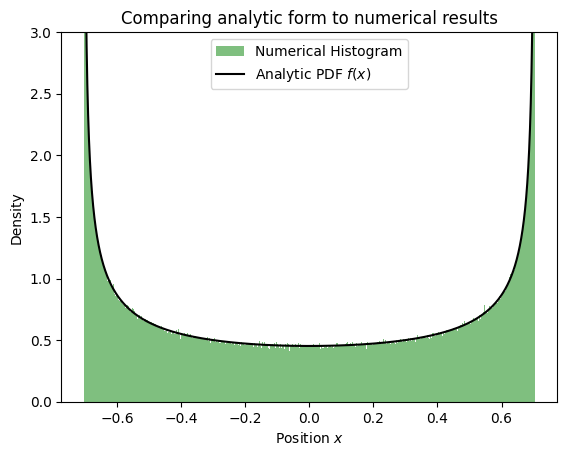

In [25]:
A = 0.7035  # arbitrarily choosing an oscillation amplitude

# creating samples in x and t
time_samples = np.random.uniform(-np.pi, np.pi, 1000000)
position_samples = np.linspace(-A, A, 10000)[1:-1]  # avoiding division by 0

# computing the histogram and PDF
hist_outputs = x(time_samples, A)
PDF_outputs = f(position_samples, A)

# plotting
fig, ax = plt.subplots()
ax.hist(hist_outputs, bins=500, density=True, alpha=0.5, label='Numerical Histogram', color='green')
ax.plot(position_samples, PDF_outputs, c='k', label='Analytic PDF $f(x)$')
ax.set(title="Comparing analytic form to numerical results", ylim=(None, 3), xlabel='Position $x$', ylabel='Density')
ax.legend()
plt.show()

If you are not now convinced of this functional form, there is no saving you.

## Jitter on a pixel grid -- 1D

We want to represent this function on a pixel grid -- for now let's continue the one-dimensional case, so we will consider a simple row of $n$ pixels. Ideally, we would choose $n$ to be the minimum number of _odd_ pixels required to entirely span the oscillation amplitude -- we want it to be odd due to artefacts of generating the distribution peak on a pixel boundary. The function `optimal_kernel_size` finds this value -- however, since `jax.jit` requires static array sizes, we cannot actually use this function to set the kernel size during optimisation. We will instead have to build it with empty pixels outside of the oscillation domain. Hence, I am arbitrarily choosing `n=15`. 

In [41]:
pscale = 0.21 # choosing some arbitrary pixel scale

def optimal_kernel_size(pixel_scale, A):
    kernel_size = np.ceil(2 * A / pixel_scale).astype(int)
    kernel_size += 1 - kernel_size % 2  # ensuring odd integer
    return kernel_size

n = 15  # arbitrary
print(f"npix = {n}")

npix = 15


We can use the `nd_coords` function from `dLux.utils` to find the coordinates of the pixel edges and centres. These are crucial to have,
 as we will see further on.

In [42]:
from dLux.utils import nd_coords

pixel_centres = nd_coords(npixels=n, pixel_scales=pscale)
pixel_edges = nd_coords(npixels=n+1, pixel_scales=pscale)

Let's visualise how our PDF lies on top of our pixel grid.

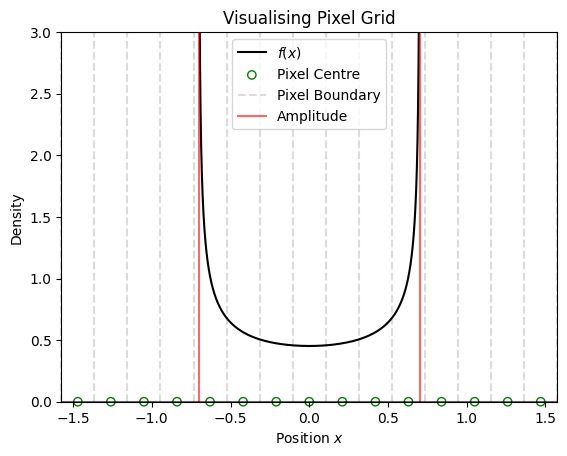

In [43]:
fig, ax = plt.subplots()
ax.plot(position_samples, PDF_outputs, c='k', label='$f(x)$')
ax.scatter(pixel_centres, jnp.zeros(n), marker='o', facecolors='none', edgecolors='green', label="Pixel Centre", clip_on=False)

ax.axvline(pixel_edges[0], c='k', linestyle='--', alpha=0.14, label='Pixel Boundary', clip_on=False)
for edge in pixel_edges[1:]:
    ax.axvline(edge, c='k', linestyle='--', alpha=0.14, clip_on=False)

ax.axvline(A, c='r', linestyle='-', alpha=0.6, label='Amplitude')
ax.axvline(-A, c='r', linestyle='-', alpha=0.6)
ax.axhline(0, c='k', linestyle='-', alpha=0.6)
ax.set(title="Visualising Pixel Grid", ylim=(0., 3), xlim=(-n*pscale/2, n*pscale/2), xlabel='Position $x$', ylabel='Density')
ax.legend()
plt.show()

We want to define the _flux_ of a pixel as the area under $f(x)$ contained within that pixel's boundaries. This will be done by integrating $f(x)$ over the pixel -- we can _trivially_ see from above that this integral is simply $\pi t(x)$. That is, for a pixel bounded by $a$ and $b$:

$$ \text{flux} = \int_{a}^{b} f(x) \, dx = \pi \left[ t(x) \right]_a ^b = \pi \left[ \arcsin\left(\frac{x}{A}\right) \right]_a ^b = \pi \left( \arcsin\left(\frac{a}{A}\right) - \arcsin\left(\frac{b}{A}\right) \right)$$

This is why we needed the coordinates for our pixel boundaries. Let's define our $t(x)$ function:

In [44]:
def t(x, A):
    return jnp.arcsin(x/A)

And now let us compute the flux using the above formula for all pixels. A slight caveat: since $f(x)$ is not defined outside the oscillation domain (technically it should have a value of $0$), we will instead have to assume all pixel boundaries falling to the left (right) of the oscillation domain are $-A$ ($A$). Cleverly (if I say so myself), this will not change the value of the integral.

In [45]:
# creating new array for integral evaluation
effective_pixel_edges = pixel_edges

# replacing all pixels boundary values outside the oscillation domain with -A or A
effective_pixel_edges = np.where(effective_pixel_edges < -A, -A, effective_pixel_edges)
effective_pixel_edges = np.where(effective_pixel_edges > A, A, effective_pixel_edges)

# calculating fluxes
fluxes = jnp.pi * (t(effective_pixel_edges[1:], A) - t(effective_pixel_edges[:-1], A))
# Since we will later normalise the kernel, this factor of pi out the front of fluxes is unnecessary

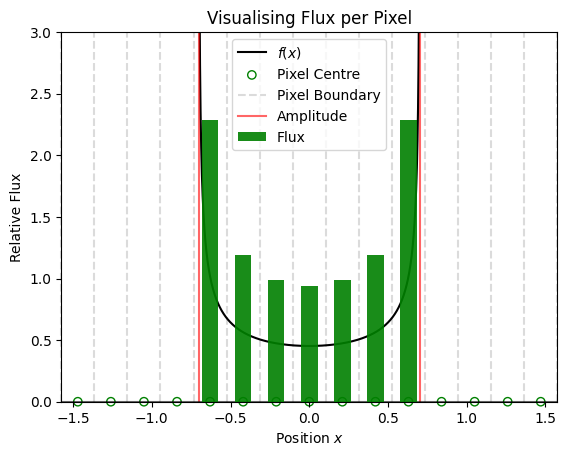

In [46]:
fig, ax = plt.subplots()

ax.bar(pixel_centres, height=fluxes, width=0.5*pscale, label="Flux", zorder=10, alpha=0.9, color='green')
ax.plot(position_samples, PDF_outputs, c='k', label='$f(x)$')
ax.scatter(pixel_centres, np.zeros(n), marker='o', facecolors='none', edgecolors='green', label="Pixel Centre", clip_on=False)

ax.axvline(pixel_edges[0], c='k', linestyle='--', alpha=0.14, label='Pixel Boundary', clip_on=False)
for edge in pixel_edges[1:]:
    ax.axvline(edge, c='k', linestyle='--', alpha=0.14, clip_on=False)

ax.axvline(A, c='r', linestyle='-', alpha=0.6, label='Amplitude')
ax.axvline(-A, c='r', linestyle='-', alpha=0.6)
ax.axhline(0, c='k', linestyle='-', alpha=0.6)
ax.set(title="Visualising Flux per Pixel", ylim=(0., 3), xlim=(-n*pscale/2, n*pscale/2), xlabel='Position $x$', ylabel='Relative Flux')
ax.legend()
plt.show()

Perfect! Note that although the maxima of $f(x)$ exist in the pixels containing the oscillation amplitudes, the flux peaks occur in the _adjacent_ pixels, as only a fraction of the outer pixels overlap with the domain of $f(x)$. This will not always be the case, as it depends on the location of $A$ within the outer pixel.

## Jitter on a pixel grid -- 2D
Now it's time for the big leagues. To create a 2D pixel grid, let's simply place our 1D kernel in the middle of an array of zeroes.

In [47]:
zero_pad = jnp.zeros(shape=(len(fluxes)//2, len(fluxes)))
kernel = jnp.vstack((zero_pad, fluxes, zero_pad))
kernel = kernel / jnp.sum(kernel)  # normalising the kernel

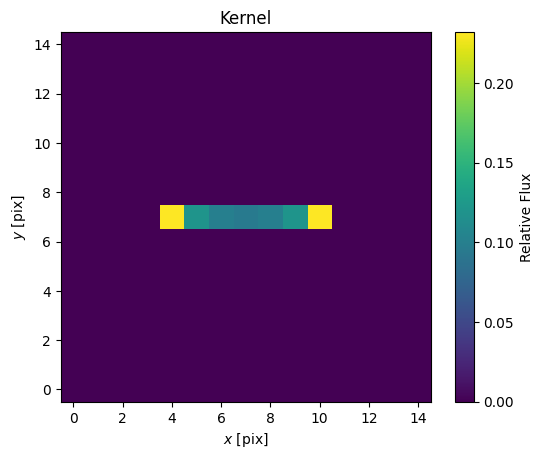

In [48]:
fig, ax = plt.subplots()
c = ax.imshow(kernel, cmap='viridis')
ax.set(
    title="Kernel",
    xlabel='$x$ [pix]',
    ylabel='$y$ [pix]',
)
fig.colorbar(c, label='Relative Flux')
plt.show()

Let's add a second parameter $\phi$, representing the rotation angle of the jitter. This will transform the kernel via a rotation matrix, which is performed by the `dLux.utils.rotate` function.

In [51]:
from dLux.utils import rotate

# define the rotation angle
phi = 30  # in degrees

rotated_kernel = rotate(kernel, jnp.radians(phi))
rotated_kernel /=  jnp.sum(rotated_kernel)

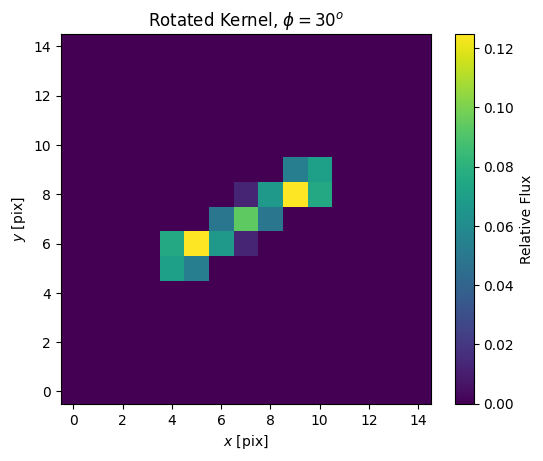

In [52]:

# plot the rotated kernel
fig, ax = plt.subplots()
c = ax.imshow(rotated_kernel, cmap='viridis')
ax.set(
    title="Rotated Kernel, $\phi=30 ^o$",
    xlabel='$x$ [pix]',
    ylabel='$y$ [pix]',
)
fig.colorbar(c, label='Relative Flux')
plt.show()


## Convolving with an image
Let's take the AMI PSF image from JWST as an example image (I would use the Toliman PSF but it is better visualised by the JWST NRM PSF).

In [53]:
import dLuxWebbpsf as dlW
from jax.scipy.signal import convolve

# initialising the model
niriss = dlW.NIRISS(
    filter="F480M",
    pupil_mask="MASK_NRM",
    radial_orders=[1]
)

# the unjittered PSF
image = niriss.model()

# convolving with the kernel
jittered_image = convolve(image, rotated_kernel, mode='same')


Great. Let's plot and have a peek at the outcome of all my amazing work.

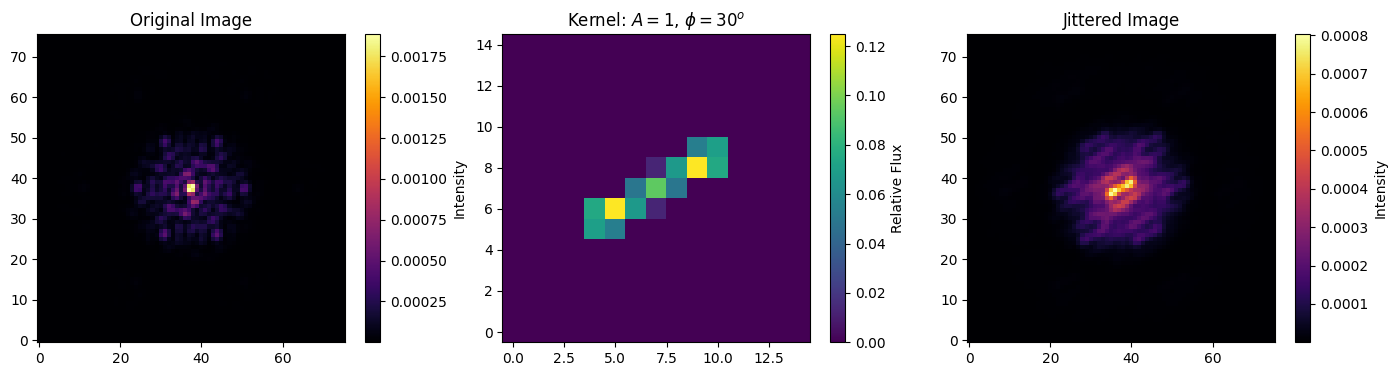

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(17, 4))

# plot original image
im0 = axs[0].imshow(image, cmap='inferno')
axs[0].set_title('Original Image')
fig.colorbar(im0, ax=axs[0], label='Intensity')

# plot kernel
im1 = axs[1].imshow(rotated_kernel, cmap='viridis')
axs[1].set_title('Kernel: $A=1$, $\phi=30 ^o$')
fig.colorbar(im1, ax=axs[1], label='Relative Flux')

# plot jittered image
im2 = axs[2].imshow(jittered_image, cmap='inferno')
axs[2].set_title('Jittered Image')
fig.colorbar(im2, ax=axs[2], label='Intensity')

plt.show()


Cool! This is obviously a massively exaggerated example. In practice you would probably perform the convolution on an oversampled PSF for better results. The next steps are to package this whole process up as a `dLux` detector layer.